In [6]:
import scanpy as sc
import pandas as pd
import scvi
import numpy as np
import anndata

Load Files for Plate 7,8,9

In [7]:
plate7 = sc.read_h5ad('tahoe_data/plate7_DMSO_Dinaciclib_A549_HT-29.h5ad')
plate8 = sc.read_h5ad('tahoe_data/plate8_DMSO_Dinaciclib_A549_HT-29.h5ad')
plate9 = sc.read_h5ad('tahoe_data/plate9_DMSO_Dinaciclib_A549_HT-29.h5ad')

In [41]:
# Merge all plates into a single AnnData object
adata = anndata.concat(
    [plate7, plate8, plate9],
    keys=["plate7", "plate8", "plate9"],
    index_unique=None           # Keeps original cell barcodes
)

# Check initial cell counts per (drugconc, cell_name) group
group_counts = adata.obs.groupby(["drugconc", "cell_name"]).size()
print("Initial cell counts per group:\n", group_counts)

# Determine the minimum number of cells across all groups
min_cells = group_counts.min()
print(f"\nSampling {min_cells} cells per (drugconc, cell_name) group to balance the dataset")

# Subsample the dataset to balance all groups
balanced_idx = (
    adata.obs
    .groupby(["drugconc", "cell_name"], observed=True, group_keys=False)
    .apply(lambda x: x.sample(min_cells, random_state=0))
    .index
)
adata = adata[balanced_idx].copy()

# Confirm the balanced group sizes
balanced_counts = adata.obs.groupby(["drugconc", "cell_name"],observed=True).size()
print("\nBalanced cell counts per group:\n", balanced_counts)

adata.write("adata_balanced.h5ad")


Initial cell counts per group:
 drugconc  cell_name
0.00      A549         10857
          HT-29         8866
0.05      A549           448
          HT-29          546
0.50      A549           923
          HT-29         1207
5.00      A549           269
          HT-29          482
dtype: int64

Sampling 269 cells per (drugconc, cell_name) group to balance the dataset

Balanced cell counts per group:
 drugconc  cell_name
0.00      A549         269
          HT-29        269
0.05      A549         269
          HT-29        269
0.50      A549         269
          HT-29        269
5.00      A549         269
          HT-29        269
dtype: int64


/var/folders/k3/mmnc54pj1f990615yjp32jy00000gn/T/ipykernel_1725/414760243.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = adata.obs.groupby(["drugconc", "cell_name"]).size()
/var/folders/k3/mmnc54pj1f990615yjp32jy00000gn/T/ipykernel_1725/414760243.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_cells, random_state=0))


In [10]:
adata
adata.layers["counts"] = adata.X.copy()  # preserve counts

In [11]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    continuous_covariate_keys=["pcnt_mito"],
    categorical_covariate_keys=["cell_name"]
)

In [12]:
model = scvi.model.SCVI(adata)

In [14]:
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False


In [15]:
model.train(max_epochs =100)

/Users/piamozdzanowski/anaconda3/envs/spring_2025/lib/python3.12/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/piamozdzanowski/anaconda3/envs/spring_2025/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/piamozdzanowski/anaconda3/envs/spring_2025/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` a

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [16]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=200)
sc.tl.umap(adata, min_dist=0.3)

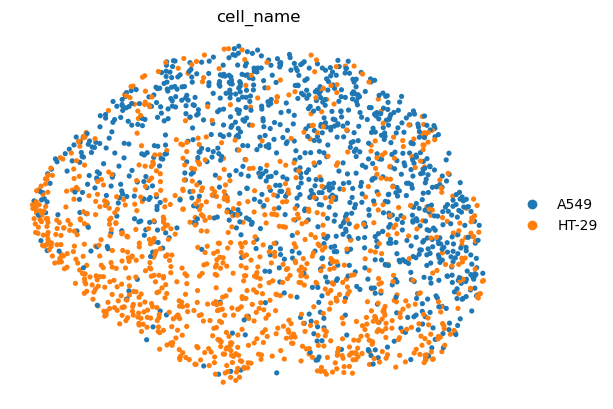

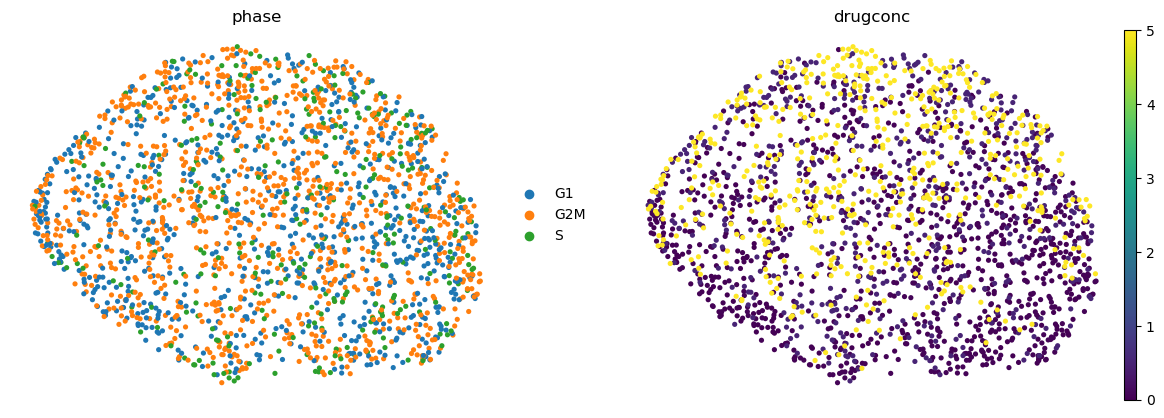

In [17]:
sc.pl.umap(
    adata,
    color=["cell_name"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["phase", "drugconc"],
    ncols=2,
    frameon=False,
)

In [18]:
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
adata.obsm[SCVI_LATENT_KEY] = latent
latent.shape

(2152, 10)

In [19]:
import os

# Create the 'models' folder if it doesn't exist
os.makedirs("models", exist_ok=True)

# Define full path to save the model
model_dir = os.path.join("models", "scvi_model_100_cell_type")

# Save the model
model.save(model_dir, overwrite=True)

In [30]:
print(adata.obs["drugconc"].unique())
ordered_conc = [0,0.05,0.5,5]
adata.obs["drugconc_ordered"] = pd.Categorical(
    adata.obs["drugconc"],
    categories=ordered_conc,
    ordered=True
)
print(adata.obs["drugconc_ordered"].unique())

[0.   0.05 0.5  5.  ]
[0.00, 0.05, 0.50, 5.00]
Categories (4, float64): [0.00 < 0.05 < 0.50 < 5.00]


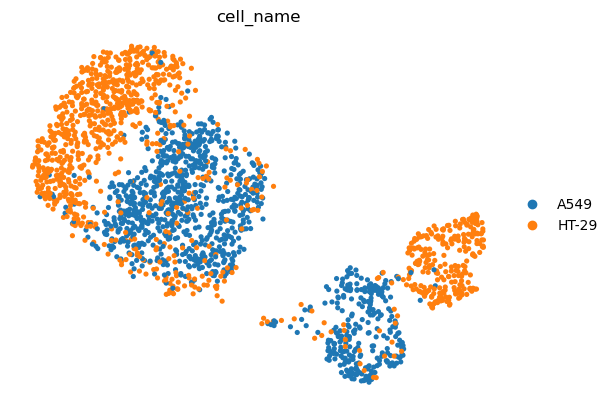

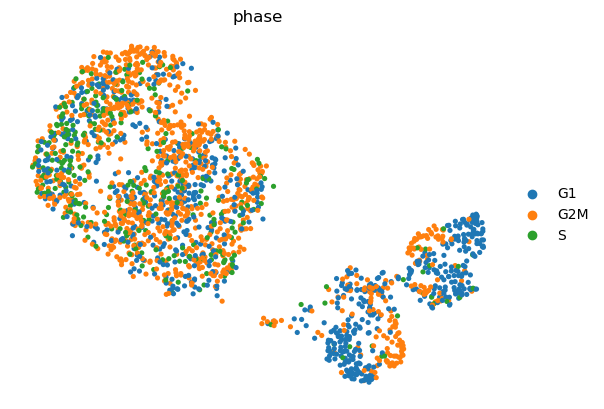

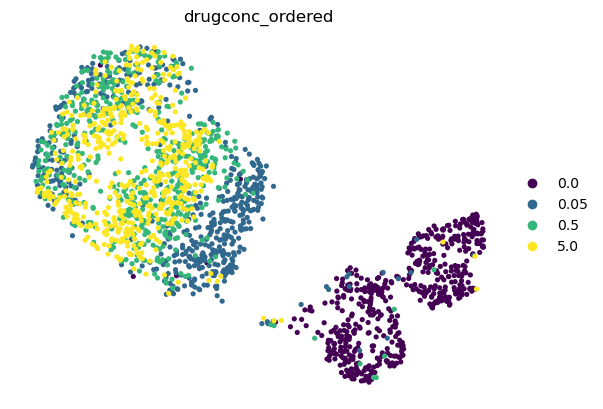

In [35]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata, min_dist=0.3)

sc.pl.umap(
    adata,
    color=["cell_name"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["phase"],
    frameon=False,
)

sc.pl.umap(
    adata,
    color=["drugconc_ordered"],
    frameon=False,
    palette="viridis"
)

In [22]:
import matplotlib.pyplot as plt
plt.colormaps()

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'berlin',
 'managua',
 'vanimo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'grey',
 'gist_grey',
 'gist_yerg',
 'Grays',
 'magma_r',

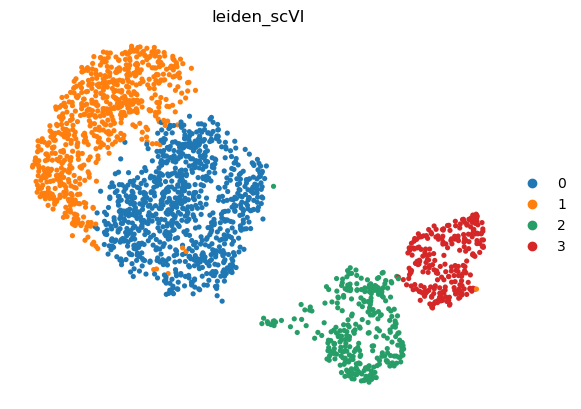

In [38]:
# neighbors were already computed using scVI
SCVI_CLUSTERS_KEY = "leiden_scVI"
sc.tl.leiden(adata, key_added=SCVI_CLUSTERS_KEY, resolution=0.3)
sc.pl.umap(
    adata,
    color=[SCVI_CLUSTERS_KEY],
    frameon=False,
)

In [40]:
import scanpy as sc
import scvi
import numpy as np
import pandas as pd

# Step 1: Get clusters from scVI latent space
SCVI_CLUSTERS_KEY = "leiden_scVI"

# Assuming neighbors were computed from scVI latent representation
sc.tl.leiden(adata, key_added=SCVI_CLUSTERS_KEY, resolution=0.5)

de_df = model.differential_expression(groupby=SCVI_CLUSTERS_KEY, mode="change")

# Step 3: Extract top 3 marker genes per cluster
markers = {}
clusters = adata.obs[SCVI_CLUSTERS_KEY].cat.categories

for cluster in clusters:
    cid = f"{cluster} vs Rest"
    df = de_df[de_df.comparison == cid]
    df = df[df.lfc_mean > 0]
    df = df[df.bayes_factor > 3]
    df = df[df.non_zeros_proportion1 > 0.1]
    markers[cluster] = df.sort_values("bayes_factor", ascending=False).index[:3].tolist()



DE...:   0%|          | 0/6 [00:00<?, ?it/s]

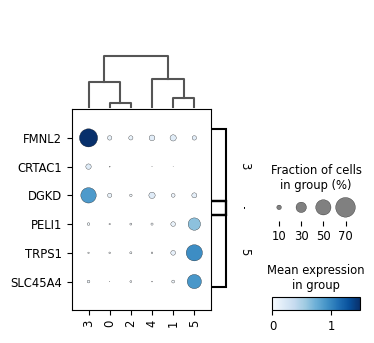

In [39]:
# Step 4: Make a dotplot grouped by cluster
sc.tl.dendrogram(adata, groupby="cell_type", use_rep="X_scVI")

sc.pl.dotplot(
    adata,
    markers,
    groupby=SCVI_CLUSTERS_KEY,
    dendrogram=True,
    color_map="Blues",
    swap_axes=True
)
